In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
DATA_FOLDER = "data_parquet"     # Where your raw files are
OUTPUT_FOLDER = "data_cleaned"   # Where we save processed files
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Market Hours (New York Time)
MARKET_OPEN = "09:30"
MARKET_CLOSE = "16:00"
TIMEZONE = "America/New_York"

print("Setup Complete. Ready to clean.")

Setup Complete. Ready to clean.


In [55]:
dtfr = dtfr.reset_index(level=0, drop=True)



In [62]:
print(dtfr.head())

                                    open    high     low   close  volume  \
symbol timestamp                                                           
TSLA   2020-01-01 00:10:00+00:00  418.75  418.75  418.75  418.75   415.0   
       2020-01-01 00:23:00+00:00  418.93  418.93  418.93  418.93   218.0   
       2020-01-01 00:30:00+00:00  418.93  418.93  418.93  418.93   577.0   
       2020-01-01 00:36:00+00:00  418.75  418.75  418.75  418.75   454.0   
       2020-01-01 00:37:00+00:00  418.60  418.60  418.60  418.60   759.0   

                                  trade_count    vwap  
symbol timestamp                                       
TSLA   2020-01-01 00:10:00+00:00          3.0  418.75  
       2020-01-01 00:23:00+00:00          3.0  418.93  
       2020-01-01 00:30:00+00:00          5.0  418.93  
       2020-01-01 00:36:00+00:00          5.0  418.75  
       2020-01-01 00:37:00+00:00          4.0  418.60  


In [57]:
print(type(dtfr.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [63]:
import os
import pandas as pd

def clean_stock_data(symbol):
    print(f"--- Processing {symbol} ---")

    # 1. LOAD
    file_path = f"{DATA_FOLDER}/{symbol}_1min.parquet"
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    df = pd.read_parquet(file_path)
    df = df.reset_index(level=0, drop=True)
    # 2. TIMEZONE HANDLING (Alpaca timestamps are UTC)
    if df.index.tz is None:
        df.index = df.index.tz_localize("UTC")
    df.index = df.index.tz_convert(TIMEZONE)

    # 3. KEEP ONLY REGULAR MARKET HOURS (Mon–Fri, 09:30–16:00)
    df = df[df.index.weekday < 5]
    df = df.between_time(MARKET_OPEN, MARKET_CLOSE)

    # 4. CREATE TRADING-DAY COLUMN (for session isolation)
    df["trade_date"] = df.index.date

    cleaned_days = []

    # 5. RESAMPLE *INSIDE EACH TRADING DAY ONLY*
    for _, day_df in df.groupby("trade_date"):
        day_df = day_df.drop(columns="trade_date")

        
        day_df = day_df.resample("1min").asfreq()

        
        day_df["was_filled"] = day_df["close"].isna().astype(int)

       
        price_cols = ["open", "high", "low", "close"]
        day_df[price_cols] = day_df[price_cols].ffill()

        
        day_df["volume"] = day_df["volume"].fillna(0)

        # Drop any leading NaNs (before first real candle)
        day_df = day_df.dropna()

        cleaned_days.append(day_df)

    # 6. RECOMBINE ALL DAYS
    df_clean = pd.concat(cleaned_days)

    return df_clean


In [64]:

tickers = ["AAPL", "MSFT","TSLA"] 

for ticker in tickers:
    # Step 1: Clean
    df_cleaned = clean_stock_data(ticker)
    
    #if df_cleaned is not None:
        # Step 2: Add Features
        #df_final = add_features(df_cleaned)
        

    output_path = f"{OUTPUT_FOLDER}/{ticker}_processed.parquet"
    df_cleaned.to_parquet(output_path, compression='snappy')
        
    print(f"Saved {ticker}: {len(df_cleaned)} rows. Saved to {output_path}")

print("\nAll files processed.")

--- Processing AAPL ---
Saved AAPL: 295418 rows. Saved to data_cleaned/AAPL_processed.parquet
--- Processing MSFT ---
Saved MSFT: 295056 rows. Saved to data_cleaned/MSFT_processed.parquet
--- Processing TSLA ---
Saved TSLA: 295369 rows. Saved to data_cleaned/TSLA_processed.parquet

All files processed.


In [65]:
dtfr = pd.read_parquet("data_cleaned/TSLA_processed.parquet")
print(dtfr.head())

                               open      high     low     close    volume  \
timestamp                                                                   
2020-01-02 09:30:00-05:00  424.5000  427.5000  424.39  427.0000  466924.0   
2020-01-02 09:31:00-05:00  427.2450  427.6753  425.35  426.7000  121062.0   
2020-01-02 09:32:00-05:00  426.6729  426.6729  425.59  426.2256   89229.0   
2020-01-02 09:33:00-05:00  426.1523  428.0000  426.00  427.7600  112727.0   
2020-01-02 09:34:00-05:00  427.9086  428.0000  425.71  426.0926  101787.0   

                           trade_count        vwap  was_filled  
timestamp                                                       
2020-01-02 09:30:00-05:00       2588.0  425.022302           0  
2020-01-02 09:31:00-05:00       1591.0  426.705426           0  
2020-01-02 09:32:00-05:00       1212.0  426.191204           0  
2020-01-02 09:33:00-05:00       1594.0  427.223713           0  
2020-01-02 09:34:00-05:00       1296.0  427.152916           0  


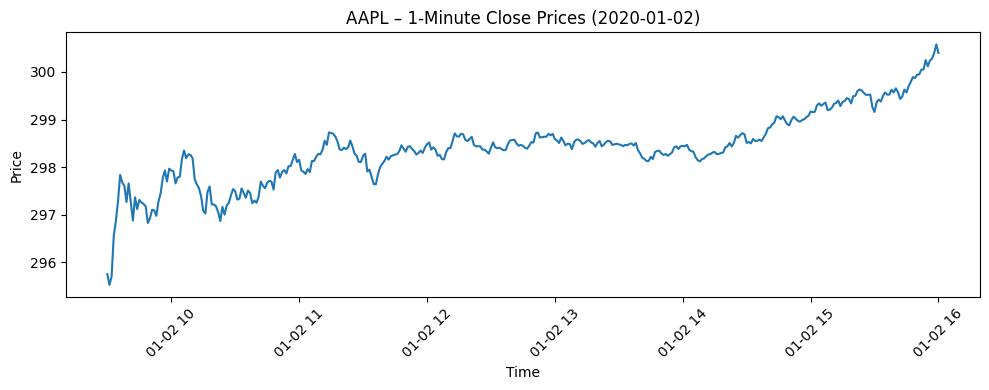

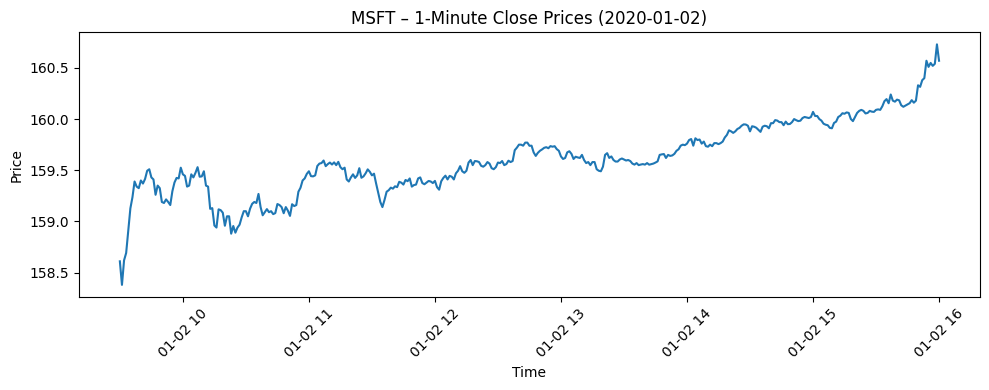

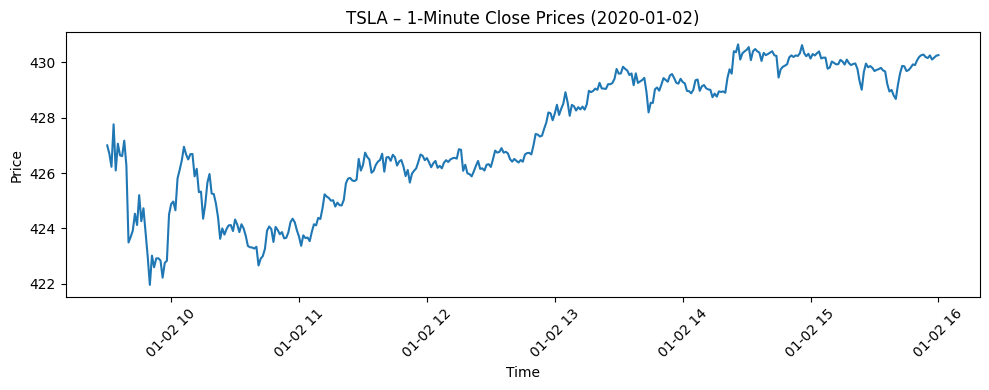

In [68]:


DATA_FOLDER = "data_cleaned"   # adjust path
SYMBOLS = ["AAPL", "MSFT", "TSLA"]
DAY = "2020-01-02"             # one valid trading day

for symbol in SYMBOLS:
    df = pd.read_parquet(f"{DATA_FOLDER}/{symbol}_processed.parquet")

    # Safety check
    assert isinstance(df.index, pd.DatetimeIndex)

    # Select one trading day
    day_df = df.loc[DAY]

    plt.figure(figsize=(10, 4))
    plt.plot(day_df.index, day_df["close"])
    plt.title(f"{symbol} – 1-Minute Close Prices ({DAY})")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
